In [1]:
import os
import numpy as np
import pandas as pd


import matplotlib
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation as animation
import seaborn as sns
import ipywidgets as widgets

import scipy 
from scipy.signal import savgol_filter
import h5py

In [2]:
import sys
sys.path.append("../code/")
from extract_angles import get_tan_angles, get_bend_angles, savgol_skeleton
from extract_curvatures import get_curv_savgol,curvature_grad

In [3]:
sample_file = "/share/data/temp/athira/Tierpsy_skeleton_files_may15/20180706_105710_1_5m0s_None_None_None_skeletons.hdf5"
# sample_file = '/share/data/longterm/10/Marios Tierpsy analysis/30042020_120fps/analysis 120fps/Results/20200430_174745_1_0m30s_None_None_None_skeletons.hdf5'
skel_obj = h5py.File(sample_file, 'r')

In [4]:
skeleton_array = np.array(skel_obj['skeleton'])
contour1_array = np.array(skel_obj['contour_side1'])
contour2_array = np.array(skel_obj['contour_side2'])
qual = np.array(skel_obj['quality'])
mask = np.array(skel_obj['selection_mask'])
neck_ind_array = np.array(skel_obj['neck_point_array'])
skel_len_array = np.array(skel_obj['skeleton_length'])

In [5]:
# Apply NaN mask 
skeleton_array = skeleton_array[mask,:,:]
contour1_array = contour1_array[mask,:,:]
contour2_array = contour2_array[mask,:,:]
neck_ind_array = neck_ind_array[mask]

skeleton_array.shape

(7980, 49, 2)

In [6]:
slider_frame = widgets.IntSlider(value= 2951,
                                        min=0,
                                        max= skeleton_array.shape[0]-1,
                                        step=1,
                                        description='Frames:',
                                        disabled=False,
                                        continuous_update=False,
                                        orientation='horizontal',
                                        readout=True,
                                        readout_format='d')

c_pal = sns.color_palette("hls",9)

@widgets.interact
def plot_ciona_segments(ind = slider_frame):
    
    
    sample_skel = skeleton_array[ind,:,:] 
    sample_cont1 = contour1_array[ind,:,:] 
    sample_cont2 = contour2_array[ind,:,:] 
    
    fig, axes = plt.subplots(1,1,figsize=(5,5))

    axes.scatter(sample_skel[:,0],sample_skel[:,1], s=2)
    axes.plot(sample_cont1[:,0],sample_cont1[:,1])
    axes.plot(sample_cont2[:,0],sample_cont2[:,1])
    c12_x = np.concatenate((sample_cont1[:,0],np.flipud(sample_cont2[:,0])))
    c12_y = np.concatenate((sample_cont1[:,1],np.flipud(sample_cont2[:,1])))
    axes.fill(c12_x,c12_y, alpha= 0.7, label=skel_len_array[ind])
    axes.axis('equal')
    

interactive(children=(IntSlider(value=2951, continuous_update=False, description='Frames:', max=7979), Output(…

In [7]:
curv_array = get_curv_savgol(skeleton_array)

In [8]:
# function to find the coordinates of the point Q (x2,y2) at a distance d on from a given point P(x1,y1) 
# such that the line that joins P and Q have a slope m

def get_end_point(x1,y1,m,d):
    
    x2 = x1 + d*(1/(np.sqrt(1+(m**2))))
    y2 = y1 + d*(m/(np.sqrt(1+(m**2))))
    
    return [x2,y2]

Let us try to draw a tangent and the oscillating circle at skeleton point 15. The circle can be drawn using the curvature value calculated using the savgol filter- differentiator.

-52.90048740256752
635.8468 554.0122540679104
[635.8468 554.    ]
[655.7643930062276, 603.0199180225437]


/share/python-virtual-environments/ciona_behaviour/lib/python3.6/site-packages/ipykernel_launcher.py:83: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


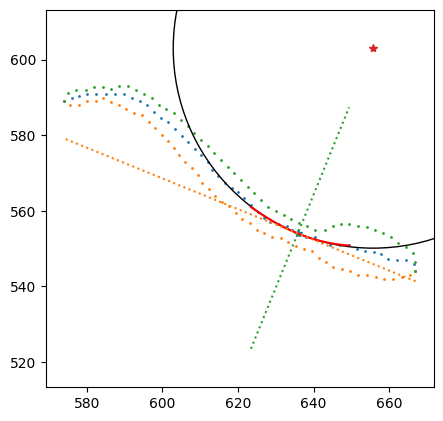

In [9]:
ind = 2956
skel_point = 15

xData = skeleton_array[ind,9:23,0]
yData = skeleton_array[ind,9:23,1]

# polynomial curve fit the test data
fittedParameters = np.polyfit(xData, yData, 2)


##########################################################
# graphics output section
def ModelAndScatterPlot():
    f = plt.figure(figsize=(5,5), dpi=100)
    axes = f.add_subplot(111)

    # first the raw data as a scatter plot
    axes.scatter(skeleton_array[ind,:,0], skeleton_array[ind,:,1], s=1)
    axes.scatter(contour2_array[ind,:,0], contour2_array[ind,:,1], s=1)
    axes.scatter(contour1_array[ind,:,0], contour1_array[ind,:,1], s=1)
    axes.plot(skeleton_array[ind,skel_point,0], skeleton_array[ind,skel_point,1],  '*')

#     # create data for the fitted equation plot
#     xModel = np.linspace(min(xData), max(xData))
#     yModel = np.polyval(fittedParameters, xModel)
    
    # create data for the fitted equation plot
    xModel = np.linspace(min(xData), max(xData))
    yModel = np.polyval(fittedParameters, xModel)

    # now the model as a line plot
    axes.plot(xModel, yModel,'r')

#     axes.set_xlabel('X Data') # X axis data label
#     axes.set_ylabel('Y Data') # Y axis data label

    # polynomial derivative from np
    deriv = np.polyder(fittedParameters)
    
    
    # for plotting
    minX = min(xData)
    maxX = max(xData)

    # value of derivative (slope) at a specific X value, so
    # that a straight line tangent can be plotted at the point
    # you might place this code in a loop to animate
    pointVal = skeleton_array[ind,skel_point,0] # example X value
    y_value_at_point = np.polyval(fittedParameters, pointVal)
    slope_at_point = np.polyval(deriv, pointVal)
    
    slope_of_radius = -1 / slope_at_point

#     ylow = (minX - pointVal) * slope_at_point + y_value_at_point
#     yhigh = (maxX - pointVal) * slope_at_point + y_value_at_point
#     # now the tangent as a line plot
#     axes.plot([minX, maxX], [ylow, yhigh])
    
    ylow = (skeleton_array[ind,0,0] - pointVal) * slope_at_point + y_value_at_point
    yhigh = (skeleton_array[ind,-1,0] - pointVal) * slope_at_point + y_value_at_point
    # now the tangent as a line plot
    axes.plot([skeleton_array[ind,0,0], skeleton_array[ind,-1,0]], [ylow, yhigh],':')
    
    
    ylow_r = (minX - pointVal) * slope_of_radius + y_value_at_point
    yhigh_r = (maxX - pointVal) * slope_of_radius + y_value_at_point
    # now the radii as a line plot
    axes.plot([minX, maxX], [ylow_r, yhigh_r],':')
    
    # Drawing the osculating circle
    print(1/curv_array[ind,skel_point])
    print(pointVal, y_value_at_point)
    print(skeleton_array[ind,skel_point])
    
    centre_osc_circle = get_end_point(pointVal, y_value_at_point,slope_of_radius,-1/curv_array[ind,skel_point])
    print(centre_osc_circle)
    axes.plot(centre_osc_circle[0], centre_osc_circle[1],  '*')
    
    a_circle = plt.Circle((centre_osc_circle[0], centre_osc_circle[1]), -1/curv_array[ind,skel_point], fc='none',ec='k')
    axes.add_artist(a_circle)

    
    plt.axes().axis('equal')
    plt.show()
    plt.close('all') # clean up after using pyplot


ModelAndScatterPlot()


Now let us try to draw a tangent and the oscillating circle at skeleton point 40. The circle can be drawn using the curvature value calculated using the savgol filter- differentiator.

23.661647868983263
591.933 589.638976614071
[591.933 590.   ]
[583.1336632392789, 567.6743335572767]


/share/python-virtual-environments/ciona_behaviour/lib/python3.6/site-packages/ipykernel_launcher.py:80: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


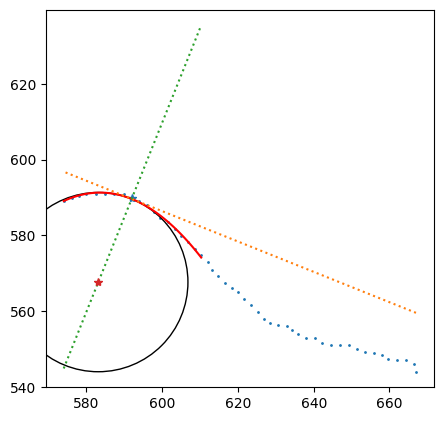

In [10]:
skel_point_2 = 40

xData = skeleton_array[ind,30:49,0]
yData = skeleton_array[ind,30:49,1]

# polynomial curve fit the test data
fittedParameters = np.polyfit(xData, yData, 2)


##########################################################
# graphics output section
def ModelAndScatterPlot():
    f = plt.figure(figsize=(5,5), dpi=100)
    axes = f.add_subplot(111)

    # first the raw data as a scatter plot
    axes.scatter(skeleton_array[ind,:,0], skeleton_array[ind,:,1], s=1)
    axes.plot(skeleton_array[ind,skel_point_2,0], skeleton_array[ind,skel_point_2,1],  '*')

#     # create data for the fitted equation plot
#     xModel = np.linspace(min(xData), max(xData))
#     yModel = np.polyval(fittedParameters, xModel)
    
    # create data for the fitted equation plot
    xModel = np.linspace(min(xData), max(xData))
    yModel = np.polyval(fittedParameters, xModel)

    # now the model as a line plot
    axes.plot(xModel, yModel,'r')

#     axes.set_xlabel('X Data') # X axis data label
#     axes.set_ylabel('Y Data') # Y axis data label

    # polynomial derivative from np
    deriv = np.polyder(fittedParameters)
    
    
    # for plotting
    minX = min(xData)
    maxX = max(xData)

    # value of derivative (slope) at a specific X value, so
    # that a straight line tangent can be plotted at the point
    # you might place this code in a loop to animate
    pointVal = skeleton_array[ind,skel_point_2,0] # example X value
    y_value_at_point = np.polyval(fittedParameters, pointVal)
    slope_at_point = np.polyval(deriv, pointVal)
    
    slope_of_radius = -1 / slope_at_point

#     ylow = (minX - pointVal) * slope_at_point + y_value_at_point
#     yhigh = (maxX - pointVal) * slope_at_point + y_value_at_point
#     # now the tangent as a line plot
#     axes.plot([minX, maxX], [ylow, yhigh])
    
    ylow = (skeleton_array[ind,0,0] - pointVal) * slope_at_point + y_value_at_point
    yhigh = (skeleton_array[ind,-1,0] - pointVal) * slope_at_point + y_value_at_point
    # now the tangent as a line plot
    axes.plot([skeleton_array[ind,0,0], skeleton_array[ind,-1,0]], [ylow, yhigh],':')
    
    
    ylow_r = (minX - pointVal) * slope_of_radius + y_value_at_point
    yhigh_r = (maxX - pointVal) * slope_of_radius + y_value_at_point
    # now the radii as a line plot
    axes.plot([minX, maxX], [ylow_r, yhigh_r],':')
    
    # Drawing the osculating circle
    print(1/curv_array[ind,skel_point_2])
    print(pointVal, y_value_at_point)
    print(skeleton_array[ind,skel_point_2])
    
    centre_osc_circle = get_end_point(pointVal, y_value_at_point,slope_of_radius,-1/curv_array[ind,skel_point_2])
    print(centre_osc_circle)
    axes.plot(centre_osc_circle[0], centre_osc_circle[1],  '*')
    
    a_circle = plt.Circle((centre_osc_circle[0], centre_osc_circle[1]), -1/curv_array[ind,skel_point_2], fc='none',ec='k')
    axes.add_artist(a_circle)

    
    plt.axes().axis('equal')
    plt.show()
    plt.close('all') # clean up after using pyplot

    

ModelAndScatterPlot()


### Let us combine the two cases of curvature for the paper 

In [11]:
# Draw the ciona (TODO : Modify for segments)

skel_savgol = savgol_skeleton(skeleton_array)
cont1_savgol = savgol_skeleton(contour1_array)
cont2_savgol = savgol_skeleton(contour2_array)

cont1_savgol[:,0,:] = skel_savgol[:,0,:]
cont2_savgol[:,0,:] = skel_savgol[:,0,:]

cont1_savgol[:,-1,:] = skel_savgol[:,-1,:]
cont2_savgol[:,-1,:] = skel_savgol[:,-1,:]

In [23]:
def body_partitions_framewise(neck):
    
    segments_ind = {        
                'neck' : [(neck-1)/48, (neck+1)/48], 
                'head' : [0, (neck-1)/48],
#                 'head_tip' : [0, int(np.round((neck-1)/2))/48],
#                 'head_base' : [int(np.round((neck-1)/2))/48, (neck-1)/48],
                'tail': [(neck+1)/48 ,1],
                'tail_base': [(neck+1)/48 ,int(np.round((49-(neck+1))/5)+(neck+1))/48],
                'tail_pre_mid': [int(np.round((49-(neck+1))/5)+(neck+1))/48, int(np.round(2*(49-(neck+1))/5)+(neck+1))/48],
                'tail_mid': [ int(np.round(2*(49-(neck+1))/5)+(neck+1))/48,int(np.round(3*(49-(neck+1))/5)+(neck+1))/48],
                'tail_post_mid': [int(np.round(3*(49-(neck+1))/5)+(neck+1))/48, int(np.round(4*(49-(neck+1))/5)+(neck+1))/48],
                'tail_tip': [int(np.round(4*(49-(neck+1))/5)+(neck+1))/48,1]
            }
    
    return segments_ind

def get_segment_indices(contour_width,neck_point):
    
    max_skel_index = contour_width.shape[-1] - 1 # default : 48
    segments_ind_dflt = body_partitions_framewise(neck_point)
    segments_ind = { k: [int(round(x[0]*max_skel_index)),int(round(x[1]*max_skel_index))] for k,x in segments_ind_dflt.items()}
    return segments_ind

def segment_contours_fw(contour_1, contour_2, segments_ind):
    
    contour_dict = {}
    
    for key, ind_bound in segments_ind.items():
        
        contour_1_x = contour_1[ind_bound[0]:ind_bound[1]+1,0]
        contour_2_x = contour_2[ind_bound[0]:ind_bound[1]+1,0]
        contour_2_x = np.flipud(contour_2_x)
        
        contour_1_y = contour_1[ind_bound[0]:ind_bound[1]+1,1]
        contour_2_y = contour_2[ind_bound[0]:ind_bound[1]+1,1]
        contour_2_y = np.flipud(contour_2_y)
        
        contour_x = np.concatenate((contour_1_x, contour_2_x))
        contour_y = np.concatenate((contour_1_y, contour_2_y))
        contour_dict[key] = np.array([contour_x, contour_y])
        
    return contour_dict

def calc_centroids_fw(segments_ind, neck_point):
    centroid_dict = {}
    
    for key, value in segments_ind.items():
        
        centroid_dict[key] = round((value[0] + value[1])/2)
    
    centroid_dict['neck'] = neck_point
#     centroid_dict['tail'] = segments_ind['tail_mid_distal'][0]
#     centroid_dict['head'] = segments_ind['head_base'][0]
    
    centroid_dict['tail'] = centroid_dict['tail_mid']
    #centroid_dict['head'] = segments_ind['head_base'][0]
    return centroid_dict

In [13]:
contour_width_array = np.array(skel_obj['contour_width'])
contour_width_array = contour_width_array[mask,:]

In [36]:
slider_frame = widgets.IntSlider(value= 2951,
                                        min=0,
                                        max= skeleton_array.shape[0]-1,
                                        step=1,
                                        description='Frames:',
                                        disabled=False,
                                        continuous_update=False,
                                        orientation='horizontal',
                                        readout=True,
                                        readout_format='d')

slider_skel_1 = widgets.IntSlider(value= 15,
                                        min=0,
                                        max= skeleton_array.shape[1]-1,
                                        step=1,
                                        description='Point 1:',
                                        disabled=False,
                                        continuous_update=False,
                                        orientation='horizontal',
                                        readout=True,
                                        readout_format='d')

slider_skel_2 = widgets.IntSlider(value= 40,
                                        min=0,
                                        max= skeleton_array.shape[1]-1,
                                        step=1,
                                        description='Point 2:',
                                        disabled=False,
                                        continuous_update=False,
                                        orientation='horizontal',
                                        readout=True,
                                        readout_format='d')




In [61]:
@widgets.interact
def illustrate_curvature(ind = slider_frame, skel_point_1 = slider_skel_1, skel_point_2 = slider_skel_2 ):
    
    plt.close()
#     xData = skeleton_array[ind,:,0]
#     yData = skeleton_array[ind,:,1]
    
    xData = skel_savgol[ind,:,0]
    yData = skel_savgol[ind,:,1]
    
    # polynomial curve fit (TODO : Modify for segments)
    window = 7
    fitted_params_1 = np.polyfit(xData[skel_point_1-window:skel_point_1+window], 
                                 yData[skel_point_1-window:skel_point_1+window], 2)
    fitted_params_2 = np.polyfit(xData[skel_point_2-window:skel_point_2+window], 
                                 yData[skel_point_2-window:skel_point_2+window], 2)
    
    # Figure settings
    f, axes = plt.subplots(1,1,figsize=(5,5), dpi=150)
    c_pal = sns.color_palette("hls",9)

    
#     axes.plot(skeleton_array[ind,:,0], skeleton_array[ind,:,1], c=c_pal[0], alpha=0.5)
#     axes.plot(contour1_array[ind,:,0], contour1_array[ind,:,1], c=c_pal[0], alpha=0.5)
#     axes.plot(contour2_array[ind,:,0], contour2_array[ind,:,1], c=c_pal[0], alpha=0.5)
    
    axes.plot(skel_savgol[ind,:,0], skel_savgol[ind,:,1], c= 'k',lw=1, alpha=0.5)
    axes.plot(cont1_savgol[ind,:,0], cont1_savgol[ind,:,1], c='k', alpha=0.5)
    axes.plot(cont2_savgol[ind,:,0], cont2_savgol[ind,:,1], c='k', alpha=0.5)
    
    
    
    
#     axes.plot(skeleton_array[ind,skel_point_1,0], skeleton_array[ind,skel_point_1,1], c=c_pal[1])
#     axes.plot(skeleton_array[ind,skel_point_2,0], skeleton_array[ind,skel_point_2,1], c=c_pal[2])
    
    
    #######################################################
    
    segments_ind = get_segment_indices(contour_width_array[ind],neck_ind_array[ind])
    contour_dict = segment_contours_fw(cont1_savgol[ind], cont2_savgol[ind], segments_ind)
    centroid_dict = calc_centroids_fw(segments_ind, neck_ind_array[ind])
    
    color_dict = {}
    for key, color in zip(contour_dict.keys(), c_pal):
        color_dict[key] = color
        
    for key, val in contour_dict.items():
        if key not in ['tail']:
            axes.fill(contour_dict[key][0],contour_dict[key][1],label=key, color = color_dict[key], alpha=0.5)
            axes.scatter(skel_savgol[ind,centroid_dict[key],0],skel_savgol[ind,centroid_dict[key],1],c='k',s=2)
        
        if skel_point_1 in range(segments_ind[key][0],segments_ind[key][1]):
            color_1 = color_dict[key]
        if skel_point_2 in range(segments_ind[key][0],segments_ind[key][1]):
            color_2 = color_dict[key]
    
    #######################################################
    window = 15
    # create data for the fitted equation plot
    min_xData1 = min(xData[skel_point_1-window:skel_point_1+window])
    max_xData1 = max(xData[skel_point_1-window:skel_point_1+window])
    min_xData2 = min(xData[skel_point_2-window:skel_point_2+window])
    max_xData2 = max(xData[skel_point_2-window:skel_point_2+window])  
    
    xModel_1 = np.linspace(min_xData1,max_xData1)
    yModel_1 = np.polyval(fitted_params_1, xModel_1)
    
    xModel_2 = np.linspace(min_xData2,max_xData2)
    yModel_2 = np.polyval(fitted_params_2, xModel_2)
    
    # now the model as a line plot
#     axes.plot(xModel_1, yModel_1,'r')
#     axes.plot(xModel_2, yModel_2,'r')
    
    ## Finding the tangent
    # polynomial derivative from np
    deriv_1 = np.polyder(fitted_params_1)
    deriv_2 = np.polyder(fitted_params_2)
    # value of derivative (slope) at a specific X value, so
    # that a straight line tangent can be plotted at the point
#     x_value_skel1 = skeleton_array[ind,skel_point_1,0]
#     x_value_skel2 = skeleton_array[ind,skel_point_2,0]
    x_value_skel1 = skel_savgol[ind,skel_point_1,0]
    x_value_skel2 = skel_savgol[ind,skel_point_2,0]
    y_value_skel1 = np.polyval(fitted_params_1, x_value_skel1)
    y_value_skel2 = np.polyval(fitted_params_2, x_value_skel2)
    
    slope_at_skel1 = np.polyval(deriv_1, x_value_skel1)
    slope_at_skel2 = np.polyval(deriv_2, x_value_skel2)
    
    ylow_1 = (min_xData1 -  x_value_skel1) * slope_at_skel1 + y_value_skel1
    yhigh_1 = (max_xData1 -  x_value_skel1) * slope_at_skel1 + y_value_skel1
    # now the tangent as a line plot
    axes.plot([min_xData1, max_xData1], [ylow_1, yhigh_1],c=color_1,ls='-.',lw=1)
    
    ylow_2 = (min_xData2 -  x_value_skel2) * slope_at_skel2 + y_value_skel2
    yhigh_2 = (max_xData2 -  x_value_skel2) * slope_at_skel2 + y_value_skel2
    # now the tangent as a line plot
    axes.plot([min_xData2, max_xData2], [ylow_2, yhigh_2],c=color_2,ls='-.',lw=1)
    
    
    ## Plotting the circles and perpendiculars
    
    # Slope of the perpendicular
    slope_of_rad1 = -1 / slope_at_skel1
    slope_of_rad2 = -1 / slope_at_skel2
    
#     ylow_r1 = (min_xData1 -  x_value_skel1) * slope_of_rad1 + y_value_skel1
#     yhigh_r1 = (max_xData1 -  x_value_skel1) * slope_of_rad1 + y_value_skel1
#     # now the perpendiculars as a line plot
#     axes.plot([min_xData1, max_xData1], [ylow_r1, yhigh_r1],':')
    
#     min_xData2_temp = min(xData[skel_point_2-1:skel_point_2+2])
#     max_xData2_temp = max(xData[skel_point_2-1:skel_point_2+2])
#     ylow_r2 = (min_xData2_temp -  x_value_skel2) * slope_of_rad2 + y_value_skel2
#     yhigh_r2 = (max_xData2_temp -  x_value_skel2) * slope_of_rad2 + y_value_skel2
#     # now the tangent as a line plot
#     axes.plot([min_xData2, max_xData2], [ylow_r2, yhigh_r2],':')
    
    # Drawing the osculating circle
    rad_1 = 1/curv_array[ind,skel_point_1]
    rad_2 = 1/curv_array[ind,skel_point_2]
                        
    centre_osc_circle_1 = get_end_point(x_value_skel1, y_value_skel1,
                                        slope_of_rad1,rad_1)
    centre_osc_circle_2 = get_end_point(x_value_skel2, y_value_skel2,
                                        slope_of_rad2,rad_2)
    
    axes.scatter(centre_osc_circle_1[0], centre_osc_circle_1[1],c=color_1,s=2)
    axes.scatter(centre_osc_circle_2[0], centre_osc_circle_2[1],c=color_2,s=2)
    
    circle_1 = plt.Circle((centre_osc_circle_1[0], centre_osc_circle_1[1]), 
                          rad_1, fc='none',ec=color_1,ls=':')
    circle_2 = plt.Circle((centre_osc_circle_2[0], centre_osc_circle_2[1]), 
                          rad_2, fc='none',ec=color_2,ls=':')
    
#     axes.plot([centre_osc_circle_1[0],skeleton_array[ind,skel_point_1,0]],
#               [centre_osc_circle_1[1], skeleton_array[ind,skel_point_1,1]],
#               c=color_1,ls='-')
    
#     axes.plot([centre_osc_circle_2[0],skeleton_array[ind,skel_point_2,0]],
#               [centre_osc_circle_2[1], skeleton_array[ind,skel_point_2,1]],
#               c=color_2,ls='-')
    
    axes.plot([centre_osc_circle_1[0],skel_savgol[ind,skel_point_1,0]],
              [centre_osc_circle_1[1], skel_savgol[ind,skel_point_1,1]],
              c=color_1,ls='-',zorder=1)
    
    axes.plot([centre_osc_circle_2[0],skel_savgol[ind,skel_point_2,0]],
              [centre_osc_circle_2[1], skel_savgol[ind,skel_point_2,1]],
              c=color_2,ls='-',zorder=1)
    
    axes.add_artist(circle_1)
    axes.add_artist(circle_2)
    
    axes.scatter(skel_savgol[ind,skel_point_1,0], skel_savgol[ind,skel_point_1,1],c='k',s=2,zorder=2)
    axes.scatter(skel_savgol[ind,skel_point_2,0], skel_savgol[ind,skel_point_2,1],c='k',s=2,zorder=2)
    
    axes.get_xaxis().set_visible(False)
    axes.get_yaxis().set_visible(False)

    axes.axis('equal')
    
    f.savefig('../figures1/curvature_definition_a.svg')

interactive(children=(IntSlider(value=5321, continuous_update=False, description='Frames:', max=7979), IntSlid…

In [ ]:
## xData = skeleton_array[ind,30:49,0]
yData = skeleton_array[ind,30:49,1]

# polynomial curve fit the test data
fittedParameters = np.polyfit(xData, yData, 2)


##########################################################
# graphics output section
def ModelAndScatterPlot():
    f = plt.figure(figsize=(5,5), dpi=100)
    axes = f.add_subplot(111)

    # first the raw data as a scatter plot
    axes.scatter(skeleton_array[ind,:,0], skeleton_array[ind,:,1], s=1)
    axes.plot(skeleton_array[ind,skel_point_2,0], skeleton_array[ind,skel_point_2,1],  '*')

#     # create data for the fitted equation plot
#     xModel = np.linspace(min(xData), max(xData))
#     yModel = np.polyval(fittedParameters, xModel)
    
    # create data for the fitted equation plot
    xModel = np.linspace(min(xData), max(xData))
    yModel = np.polyval(fittedParameters, xModel)

    # now the model as a line plot
    axes.plot(xModel, yModel,'r')

#     axes.set_xlabel('X Data') # X axis data label
#     axes.set_ylabel('Y Data') # Y axis data label

    # polynomial derivative from np
    deriv = np.polyder(fittedParameters)
    
    
    # for plotting
    minX = min(xData)
    maxX = max(xData)

    # value of derivative (slope) at a specific X value, so
    # that a straight line tangent can be plotted at the point
    # you might place this code in a loop to animate
    pointVal = skeleton_array[ind,skel_point_2,0] # example X value
    y_value_at_point = np.polyval(fittedParameters, pointVal)
    slope_at_point = np.polyval(deriv, pointVal)
    
    slope_of_radius = -1 / slope_at_point

#     ylow = (minX - pointVal) * slope_at_point + y_value_at_point
#     yhigh = (maxX - pointVal) * slope_at_point + y_value_at_point
#     # now the tangent as a line plot
#     axes.plot([minX, maxX], [ylow, yhigh])
    
    ylow = (skeleton_array[ind,0,0] - pointVal) * slope_at_point + y_value_at_point
    yhigh = (skeleton_array[ind,-1,0] - pointVal) * slope_at_point + y_value_at_point
    # now the tangent as a line plot
    axes.plot([skeleton_array[ind,0,0], skeleton_array[ind,-1,0]], [ylow, yhigh],':')
    
    
    ylow_r = (minX - pointVal) * slope_of_radius + y_value_at_point
    yhigh_r = (maxX - pointVal) * slope_of_radius + y_value_at_point
    # now the radii as a line plot
    axes.plot([minX, maxX], [ylow_r, yhigh_r],':')
    
    # Drawing the osculating circle
    print(1/curv_array[ind,skel_point_2])
    print(pointVal, y_value_at_point)
    print(skeleton_array[ind,skel_point_2])
    
    centre_osc_circle = get_end_point(pointVal, y_value_at_point,slope_of_radius,-1/curv_array[ind,skel_point_2])
    print(centre_osc_circle)
    axes.plot(centre_osc_circle[0], centre_osc_circle[1],  '*')
    
    a_circle = plt.Circle((centre_osc_circle[0], centre_osc_circle[1]), -1/curv_array[ind,skel_point_2], fc='none',ec='k')
    axes.add_artist(a_circle)

    
    plt.axes().axis('equal')
    plt.show()
    plt.close('all') # clean up after using pyplot

    

ModelAndScatterPlot()

